In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import SparsePCA, TruncatedSVD
from scipy.sparse import csc_matrix
from sklearn.manifold import TSNE

sns.set_style('whitegrid')

In [3]:
def load_dictionary(path='dataframes/dictionary.gensim'):
    return Dictionary.load(path)

In [4]:
def load_corpus(path='dataframes/corpus.pkl'):
    with open(path, 'rb') as file:
        corpus = pickle.load(file)
    return corpus

In [5]:
dictionary = load_dictionary('dataframes/dictionary.gensim')
corpus = load_corpus('dataframes/corpus.pkl')

In [6]:
num_docs = dictionary.num_docs
num_terms = len(dictionary.keys())

print('Number of unique tokens: {}'.format(num_terms))
print('Number of documents: {}'.format(num_docs))

Number of unique tokens: 7037
Number of documents: 3889


In [7]:
# Transform BOW model into TF-IDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [8]:
# Transform corpus into dense/sparse matrix
use_tfidf = False

if(use_tfidf):
    corpus_dense = corpus2dense(corpus_tfidf, num_terms, num_docs)    
    corpus_sparse = corpus2csc(corpus_tfidf)                          
else:
    corpus_dense = corpus2dense(corpus, num_terms, num_docs)
    corpus_sparse = corpus2csc(corpus)
    
    
print(corpus_dense.T.shape)
print(corpus_sparse.T.shape)

(3889, 7037)
(3889, 7037)


# Feature scaling

In [9]:
mms = MinMaxScaler()
scaled_data = mms.fit_transform(corpus_sparse.T.toarray())
scaled_data.shape

(3889, 7037)

# Clustering using Kmeans

In [10]:
kmeans = KMeans(n_clusters=29)
labels = kmeans.fit_predict(scaled_data)
centroids = kmeans.cluster_centers_

# Find optimal number of clusters

In [11]:
start = 2
limit = 41
step = 1

sse = []
for i in range(start, limit, step):
    inertia = MiniBatchKMeans(n_clusters=i, random_state=33).fit(scaled_data).inertia_
    sse.append(inertia)
    print('Fit {} clusters - SSE: {}'.format(i, inertia))

Fit 2 clusters - SSE: 40901.866795347356
Fit 3 clusters - SSE: 40897.206991053274
Fit 4 clusters - SSE: 39327.558350268926
Fit 5 clusters - SSE: 40881.98033538551
Fit 6 clusters - SSE: 40882.024133045765
Fit 7 clusters - SSE: 40818.26803013682
Fit 8 clusters - SSE: 39466.98923367421
Fit 9 clusters - SSE: 40714.3270289259
Fit 10 clusters - SSE: 38413.88962329098
Fit 11 clusters - SSE: 39450.9199603357
Fit 12 clusters - SSE: 40711.20414213037
Fit 13 clusters - SSE: 39400.225923308055
Fit 14 clusters - SSE: 39491.99578258696
Fit 15 clusters - SSE: 39139.53693328102
Fit 16 clusters - SSE: 39465.7420526496
Fit 17 clusters - SSE: 39429.09884160891
Fit 18 clusters - SSE: 39240.60364579542
Fit 19 clusters - SSE: 39292.8962327942
Fit 20 clusters - SSE: 39205.94012534321
Fit 21 clusters - SSE: 38884.34771243561
Fit 22 clusters - SSE: 40696.057043776986
Fit 23 clusters - SSE: 39053.10826448946
Fit 24 clusters - SSE: 39349.836457269754
Fit 25 clusters - SSE: 39283.51167439104
Fit 26 clusters - SSE

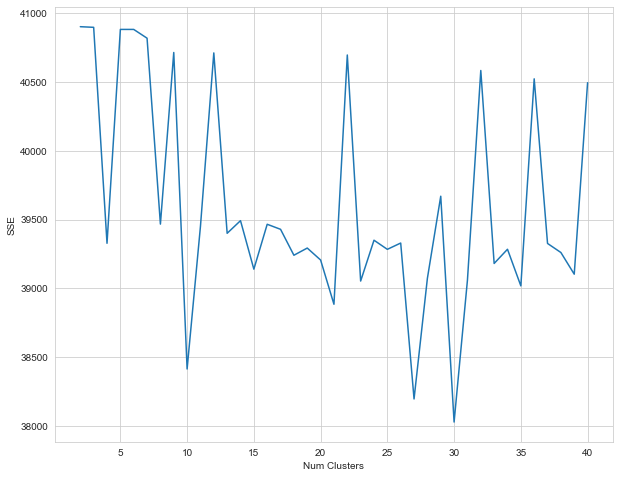

In [12]:
def plot_clustering_sse(sse, limit, start, step):
    x = range(start, limit, step)
    plt.figure(figsize=(10, 8))
    plt.plot(x, sse)
    plt.xlabel("Num Clusters")
    plt.ylabel("SSE")
    #plt.legend(("sse"), loc='best')
    
plot_clustering_sse(sse=sse, limit=limit, start=start, step=step)

In [13]:
# best kmeans model is with 30 clusters, similar to best LDA model with 29 topics!
optimal_model = MiniBatchKMeans(n_clusters=30, random_state=33)
labels = optimal_model.fit_predict(scaled_data)
centroids = optimal_model.cluster_centers_

In [14]:
print('Dimensions of clustering data: {}'.format(scaled_data.shape))
print('Dimensions of cluster centroids: {}'.format(centroids.shape))
#for word in dictionary.values():
#    print(word)

Dimensions of clustering data: (3889, 7037)
Dimensions of cluster centroids: (30, 7037)


## Append centroids to scaled data, because of t-SNE

In [15]:
all_data = np.concatenate((scaled_data, centroids), axis=0)
print('Dimensions of clustering data and centroids: {}'.format(all_data.shape))

Dimensions of clustering data and centroids: (3919, 7037)


# Top terms for each cluster

In [16]:
print("Top terms per cluster:\n")

order_centroids = centroids.argsort()[:, ::-1]

if(use_tfidf):
    terms = list({dictionary.get(id): value for doc in corpus_tfidf for id, value in doc}.keys())
else:
    terms = list(dictionary.values())

cluster_top_words = []

for i in range(30):
    print('Cluster {}'.format(i))
    words = []
    for ind in order_centroids[i, :10]:
        print(terms[ind])
        words.append(terms[ind])
    cluster_top_words.append(words)
    print()

Top terms per cluster:

Cluster 0
difficulty
latter
correct
ensure
lead
simply
assume
fully
responsibility
doubt

Cluster 1
issuer
card
certify_preceding
oxford_english
interchange
narrower
highest
incidence
recorded
functionality

Cluster 2
uncritically
immigration_multicultural
imprison
following
indonesian
plot
appellant
unable
persecute
genuineness

Cluster 3
economical
promptly
allsop
inadequacy
bill
contaminate
really
naturally
moment
reliance_placed

Cluster 4
constitute
mere
contrary
simply
meaning
consequence
enable
apparent
none
relief

Cluster 5
island
willingness
furniture
unit
branson
interpolate
establishe
changed
strenuously
commenced

Cluster 6
wrongdoer
returnable
transpire
misapply
conveniently
prayer
falsely
bench
prevail
collectively

Cluster 7
flick_associate
unrepresente
forth
certify_preceding
refused_supposing
refused
unsupported
seeking
merit
tribunal

Cluster 8
troubled
concluding
divest
judge
intolerable
removed
bias
fortunately
probability
inclination

Clust

# t-SNE dimensionality reduction

In [17]:
# first reduce dimensionality using PCA, and then pass it to t-SNE
# mala usteda vremena, t-SNE je dosta spor u ovoj situaciji
pca = PCA(n_components=1000)       # probati eventualno i SparsePCA
pca_data = pca.fit_transform(all_data)
print('Explained variation: {}'.format(np.sum(pca.explained_variance_ratio_)))

Explained variation: 0.8455768215396371


In [18]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=33)

In [19]:
tsne_res = tsne_model.fit_transform(pca_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3919 samples in 0.163s...
[t-SNE] Computed neighbors for 3919 samples in 25.976s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3919
[t-SNE] Computed conditional probabilities for sample 2000 / 3919
[t-SNE] Computed conditional probabilities for sample 3000 / 3919
[t-SNE] Computed conditional probabilities for sample 3919 / 3919
[t-SNE] Mean sigma: 0.233360
[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.537445
[t-SNE] KL divergence after 1000 iterations: 2.547661


In [20]:
tsne_df = pd.DataFrame(tsne_res[:scaled_data.shape[0], :], columns=['x1', 'x2'])
tsne_df['cluster'] = labels
tsne_df.head()

,x1,x2,cluster
0,5.516204,22.032202,4
1,-36.153553,11.415953,14
2,15.348367,7.698970,17
3,-7.556089,17.760099,0
4,-2.559481,13.633823,4


In [21]:
# get transformed points for all centroids
tsne_centroids = tsne_res[scaled_data.shape[0]:, :]

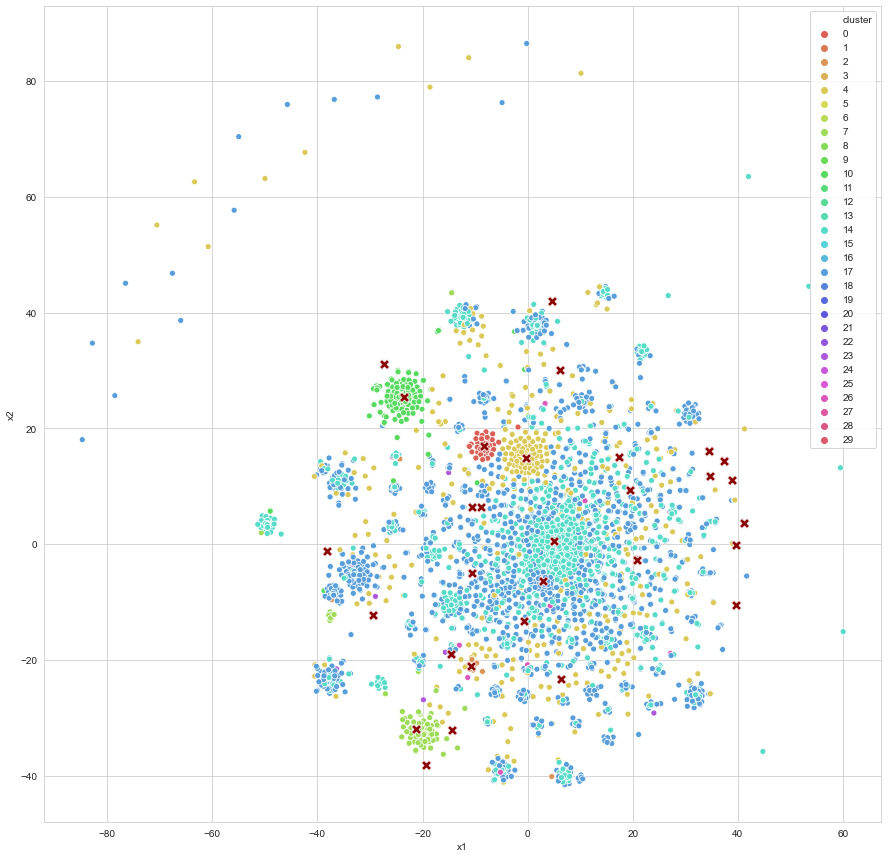

In [22]:
plt.figure(figsize=(15, 15))

sns.scatterplot(x=tsne_df['x1'], y=tsne_df['x2'], hue=tsne_df['cluster'], legend='full', palette=sns.color_palette("hls", 30))
sns.scatterplot(x=tsne_centroids[:, 0], y=tsne_centroids[:, 1], marker='X', s=100, color='darkred')

# Loading LDA topic model and visualization of topics using t-SNE

## Ovde je radjeno sa raspodelom tema za svaki dokument

In [23]:
def load_model(path='LDA model/lda.model'):
    return LdaModel.load(path)

In [24]:
lda_model = load_model('LDA model/lda.model')
num_topics = lda_model.num_topics
print('Number of topics: {}'.format(num_topics))

Number of topics: 29


In [44]:
topics_distribution = []

for doc in corpus:
    topics = [] 
    topic_pairs = lda_model.get_document_topics(doc, minimum_probability=0.0)
    
    for pair in topic_pairs:
        topics.append(pair[1])
        
    topics_distribution.append(topics)
    
print(len(topics_distribution))

3889


In [48]:
dominant_topic = np.argmax(topics_distribution, axis=1)
dominant_topic

array([ 4, 17, 24, ..., 22,  9,  4], dtype=int64)

In [49]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=33)

In [50]:
# fit t-SNE model on LDA topics
tsne_lda = tsne_model.fit_transform(topics_distribution)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3889 samples in 0.007s...
[t-SNE] Computed neighbors for 3889 samples in 1.178s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3889
[t-SNE] Computed conditional probabilities for sample 2000 / 3889
[t-SNE] Computed conditional probabilities for sample 3000 / 3889
[t-SNE] Computed conditional probabilities for sample 3889 / 3889
[t-SNE] Mean sigma: 0.094936
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.444771
[t-SNE] KL divergence after 1000 iterations: 1.328286


In [51]:
tsne_lda_df = pd.DataFrame(tsne_lda, columns=['x1', 'x2'])
tsne_lda_df['dominant_topic'] = dominant_topic

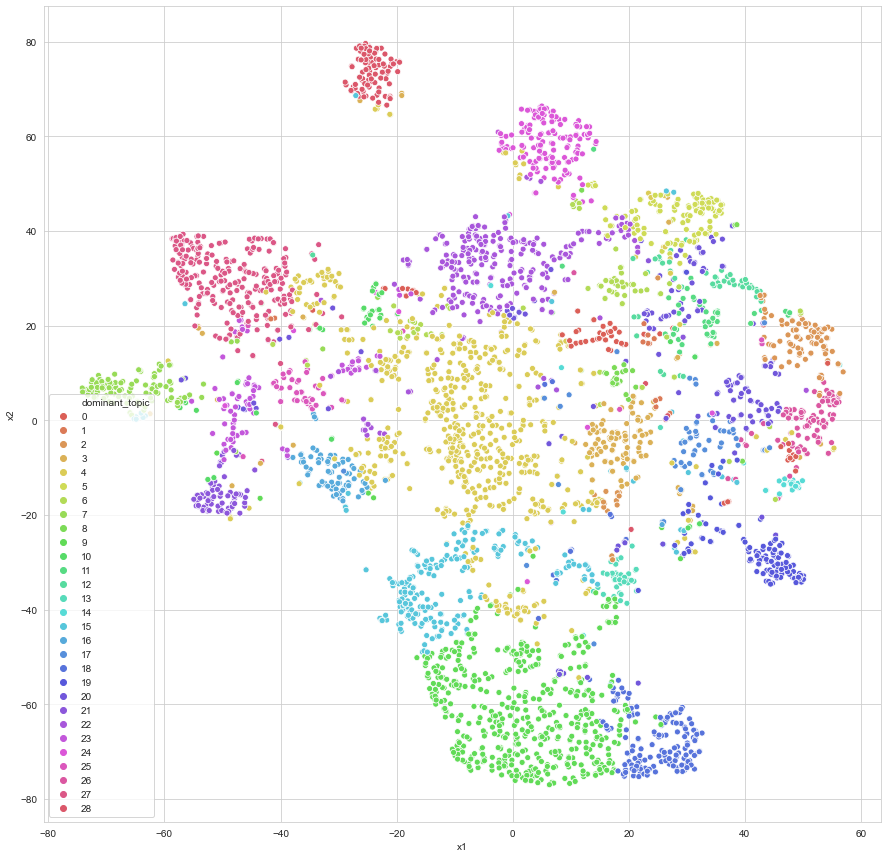

In [52]:
plt.figure(figsize=(15, 15))

sns.scatterplot(x=tsne_lda_df['x1'], y=tsne_lda_df['x2'], hue=tsne_lda_df['dominant_topic'],
                legend='full', palette=sns.color_palette("hls", 29))

# Dokument predstavljam raspodelom fraza u okviru najznacajnije teme. Tezina svake reci pomnozena je sa tezinom dominantne teme za trenutni dokument, kako bi se na neki nacin i to uzelo u obzir (moguce je i dodavanje novog featurea, slican je rezultat)

In [81]:
# num_words = all words in dictionary!
topics = lda_model.show_topics(num_topics=num_topics, num_words=num_terms, formatted=False)
len(topics[0][1])

7037

In [82]:
# topics_data je vektor od 29 elemenata, gde je svaki od elemenata vektor tezina svih reci za tu temu
topics_data = []
for topic in topics:
    weights = []
    for pair in topic[1]:
        #print(pair)
        weights.append(pair[1])
    topics_data.append(weights)

In [83]:
dominant_topic_df = pd.read_csv('dataframes/topics_of_documents.csv')
dominant_topic_df.head()

,dominant_topic,perc_contribution,topic_keywords,filename,text
0,4.0,0.3999,"relief, jurisdiction, action, final, dispute, ...",06_1.xml,background current application applicant holdi...
1,17.0,0.2325,"report, complaint, letter, request, duty, alle...",06_100.xml,application order review judicial_review conce...
2,24.0,0.3343,"client, produce, disclosure, privilege, advice...",06_1001.xml,notice motion file bring first second third ap...
3,0.0,0.1887,"agreement, contract, clause, obligation, enter...",06_1004.xml,introduction brand company know come marketing...
4,21.0,0.1860,"income, assessment, commissioner, taxpayer, en...",06_1005.xml,context present application appeal application...


In [107]:
# svaki dokument predstavlja se raspodelom reci za dominantnu temu tog dokumenta
doc_topic_keywords = []

for index, row in dominant_topic_df.iterrows():
    #document_features = []
    perc_contribution = row['perc_contribution']
    document_features = list(topics_data[int(row['dominant_topic'])])
    
    # mnozenje tezine svake reci sa tezinom dominantne teme
    document_features = [perc_contribution * value for value in document_features]
    
    #document_features.append(row['perc_contribution'])    # ukljucujem i tezinu dominantne teme kao dodatan feature (pored raspodele tezina reci dominantne teme)
    
    doc_topic_keywords.append(document_features)

In [108]:
len(doc_topic_keywords[333])

7037

In [109]:
tsne_topics_model = TSNE(n_components=2, verbose=1, random_state=33)

In [110]:
tsne_topics_data = tsne_topics_model.fit_transform(doc_topic_keywords)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3889 samples in 1.240s...
[t-SNE] Computed neighbors for 3889 samples in 33.909s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3889
[t-SNE] Computed conditional probabilities for sample 2000 / 3889
[t-SNE] Computed conditional probabilities for sample 3000 / 3889
[t-SNE] Computed conditional probabilities for sample 3889 / 3889
[t-SNE] Mean sigma: 0.000504
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.609928
[t-SNE] KL divergence after 1000 iterations: 0.325506


In [111]:
tsne_topics_df = pd.DataFrame(tsne_topics_data, columns=['x1', 'x2'])
tsne_topics_df['dominant_topic'] = list(dominant_topic_df['dominant_topic'])
tsne_topics_df.head()

,x1,x2,dominant_topic
0,23.767838,-63.649410,4.0
1,4.768532,-4.420756,17.0
2,-52.549984,4.832052,24.0
3,32.103939,-3.658521,0.0
4,9.740913,15.742590,21.0


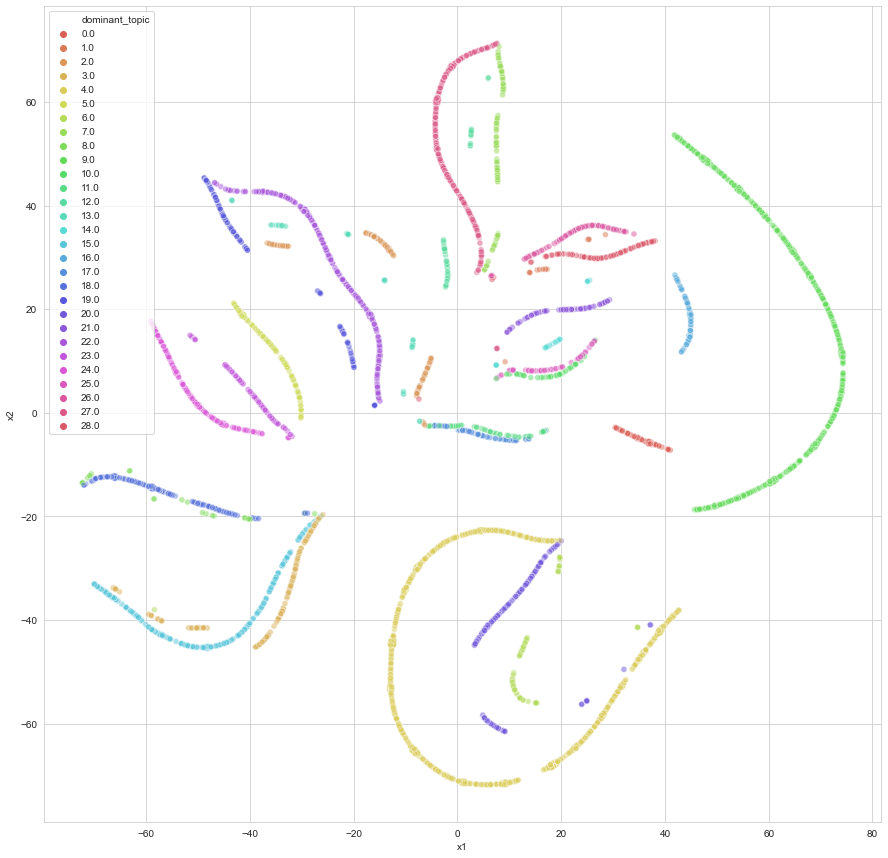

In [112]:
plt.figure(figsize=(15, 15))

sns.scatterplot(x=tsne_topics_df['x1'], y=tsne_topics_df['x2'], hue=tsne_topics_df['dominant_topic'],
                legend='full', palette=sns.color_palette("hls", 29), alpha=0.5)
#sns.scatterplot(x=tsne_centroids[:, 0], y=tsne_centroids[:, 1], marker='X', s=100, color='darkred')